In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load all CSV files from the SMNI_CMI_TRAIN and SMNI_CMI_TEST directories
train_folder = 'SMNI_CMI_TRAIN'
test_folder = 'SMNI_CMI_TEST'

train_files = [os.path.join(train_folder, f) for f in os.listdir(train_folder) if f.endswith('.csv')]
test_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith('.csv')]

train_data = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)
test_data = pd.concat([pd.read_csv(f) for f in test_files], ignore_index=True)

df = pd.concat([train_data, test_data], ignore_index=True)
print("Data loaded successfully. Shape:", df.shape)
print(df.head())


Data loaded successfully. Shape: (15532032, 10)
   Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5             0             FP1           0        -8.921   
1           6             0             FP1           1        -8.433   
2           7             0             FP1           2        -2.574   
3           8             0             FP1           3         5.239   
4           9             0             FP1           4        11.587   

  subject identifier matching condition  channel         name      time  
0                  a             S1 obj        0  co2a0000364  0.000000  
1                  a             S1 obj        0  co2a0000364  0.003906  
2                  a             S1 obj        0  co2a0000364  0.007812  
3                  a             S1 obj        0  co2a0000364  0.011719  
4                  a             S1 obj        0  co2a0000364  0.015625  


In [19]:
# Rename columns properly and handle missing values
df = df.rename(columns={
    'trial number': 'trial',
    'sample num': 'sample',
    'sensor value': 'sensor_value',
    'subject identifier': 'subject_id',
    'matching condition': 'condition',
    'sensor postition': 'sensor_position',  # Fixed typo
    'sensor position': 'sensor_position',
    'channel': 'drop_channel',
    'name': 'subject_name'
})

# Drop unnecessary columns and handle missing values
if 'drop_channel' in df.columns:
    df.drop(columns=['drop_channel'], inplace=True)

df.dropna(inplace=True)

# Convert data types to ensure consistency
df['sample'] = pd.to_numeric(df['sample'], errors='coerce')
df['sensor_value'] = pd.to_numeric(df['sensor_value'], errors='coerce')
df['time'] = pd.to_numeric(df['time'], errors='coerce')

df.reset_index(drop=True, inplace=True)

print("Data preprocessing completed. Columns:", df.columns)
print(df.head())


Data preprocessing completed. Columns: Index(['Unnamed: 0', 'trial', 'sensor_position', 'sample', 'sensor_value',
       'subject_id', 'condition', 'subject_name', 'time'],
      dtype='object')
   Unnamed: 0  trial sensor_position  sample  sensor_value subject_id  \
0           5      0             FP1       0        -8.921          a   
1           6      0             FP1       1        -8.433          a   
2           7      0             FP1       2        -2.574          a   
3           8      0             FP1       3         5.239          a   
4           9      0             FP1       4        11.587          a   

  condition subject_name      time  
0    S1 obj  co2a0000364  0.000000  
1    S1 obj  co2a0000364  0.003906  
2    S1 obj  co2a0000364  0.007812  
3    S1 obj  co2a0000364  0.011719  
4    S1 obj  co2a0000364  0.015625  


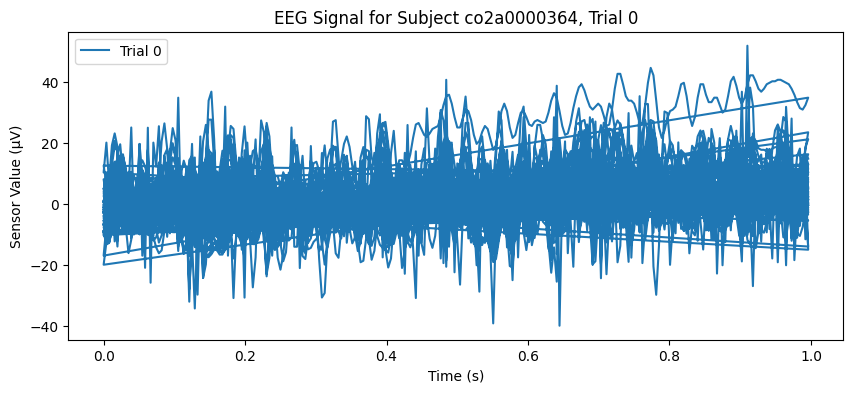

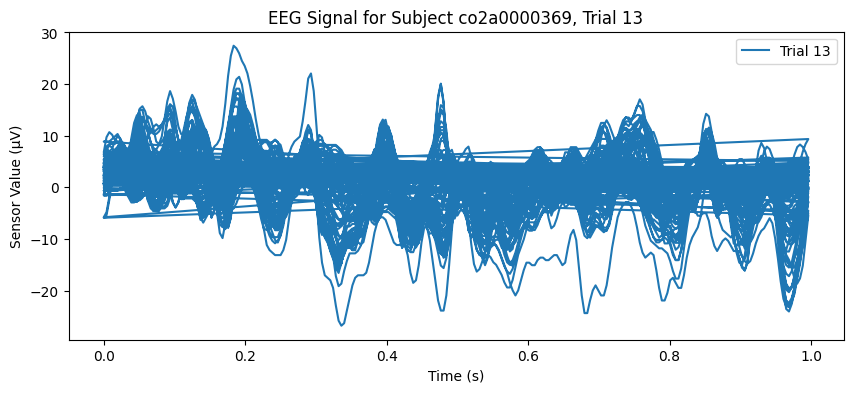

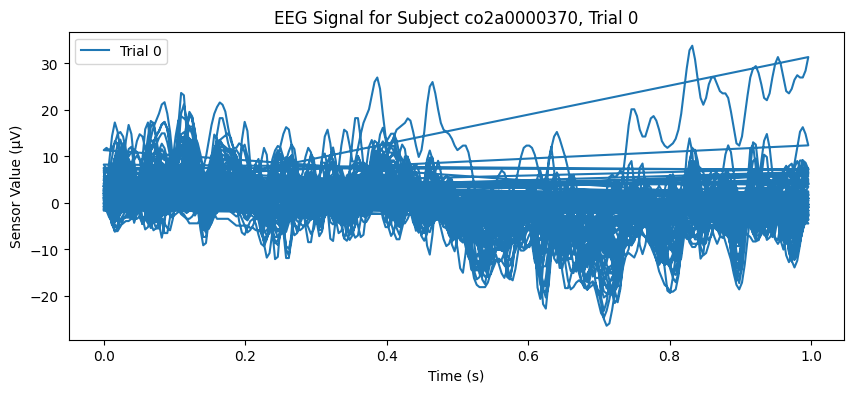

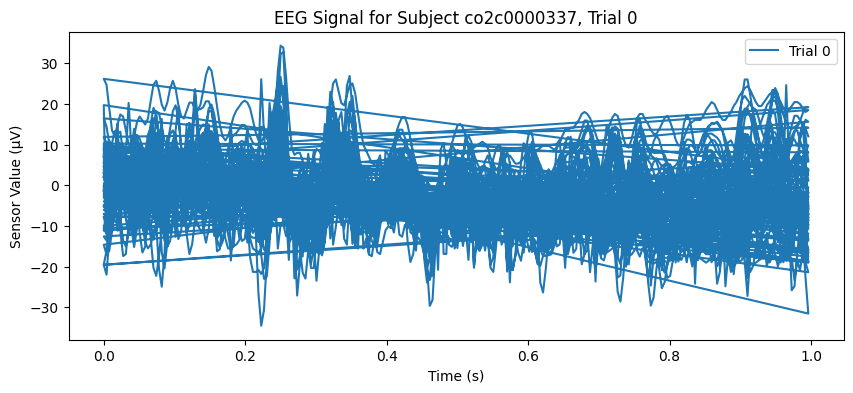

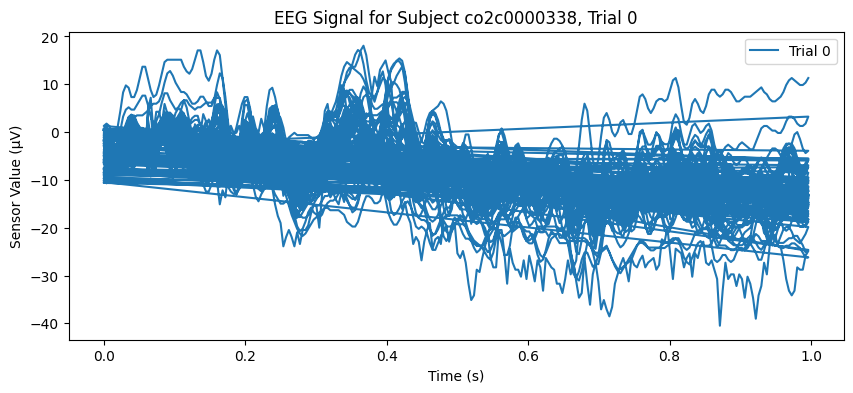

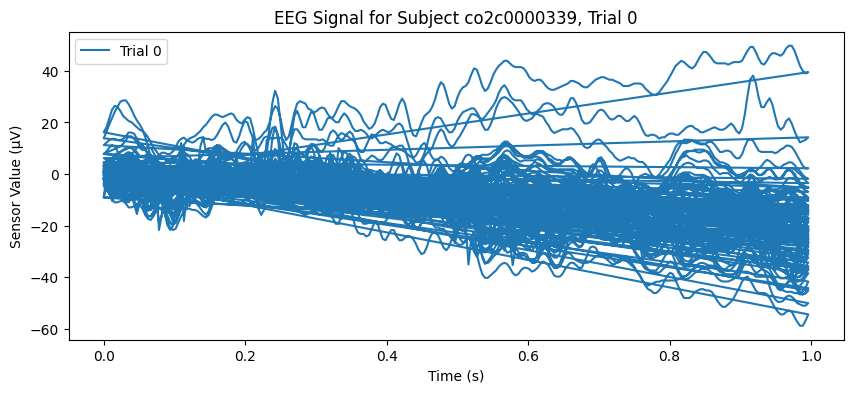

In [20]:
# Select sample subjects for visualization
alcoholic_subjects = df[df['subject_id'] == 'a']['subject_name'].unique()[:3]
control_subjects = df[df['subject_id'] == 'c']['subject_name'].unique()[:3]

def plot_trial(subject, trial_num):
    data = df[(df['subject_name'] == subject) & (df['trial'] == trial_num)]
    if not data.empty:
        plt.figure(figsize=(10, 4))
        plt.plot(data['time'], data['sensor_value'], label=f"Trial {trial_num}")
        plt.xlabel("Time (s)")
        plt.ylabel("Sensor Value (µV)")
        plt.legend()
        plt.title(f"EEG Signal for Subject {subject}, Trial {trial_num}")
        plt.show()

# Plot EEG data for sample alcoholic subjects
for subj in alcoholic_subjects:
    trial = df[df['subject_name'] == subj]['trial'].iloc[0]
    plot_trial(subj, trial)

# Plot EEG data for sample control subjects
for subj in control_subjects:
    trial = df[df['subject_name'] == subj]['trial'].iloc[0]
    plot_trial(subj, trial)


In [21]:
# Check column names to avoid KeyError
print("Columns in DataFrame:", df.columns)

# Extract features by averaging sensor values for each subject and sensor position
if 'sensor_position' in df.columns:
    features = df.groupby(['subject_name', 'sensor_position'])['sensor_value'].mean().unstack()
    labels = df.groupby('subject_name')['subject_id'].first()
    features = features.dropna()
    labels = labels.loc[features.index]
    
    labels_binary = labels.map({'a': 1, 'c': 0})
    print("Feature extraction completed. Features shape:", features.shape)
else:
    print("Error: 'sensor_position' column not found in the DataFrame!")


Columns in DataFrame: Index(['Unnamed: 0', 'trial', 'sensor_position', 'sample', 'sensor_value',
       'subject_id', 'condition', 'subject_name', 'time'],
      dtype='object')
Feature extraction completed. Features shape: (16, 64)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_binary, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Model training completed.")


Model training completed.


In [23]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 40.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5


Confusion Matrix:
 [[2 0]
 [3 0]]


c:\Users\djsce.student\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\djsce.student\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\djsce.student\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [24]:
corr_matrix = features.corr()
print("Correlation matrix computed.")


Correlation matrix computed.


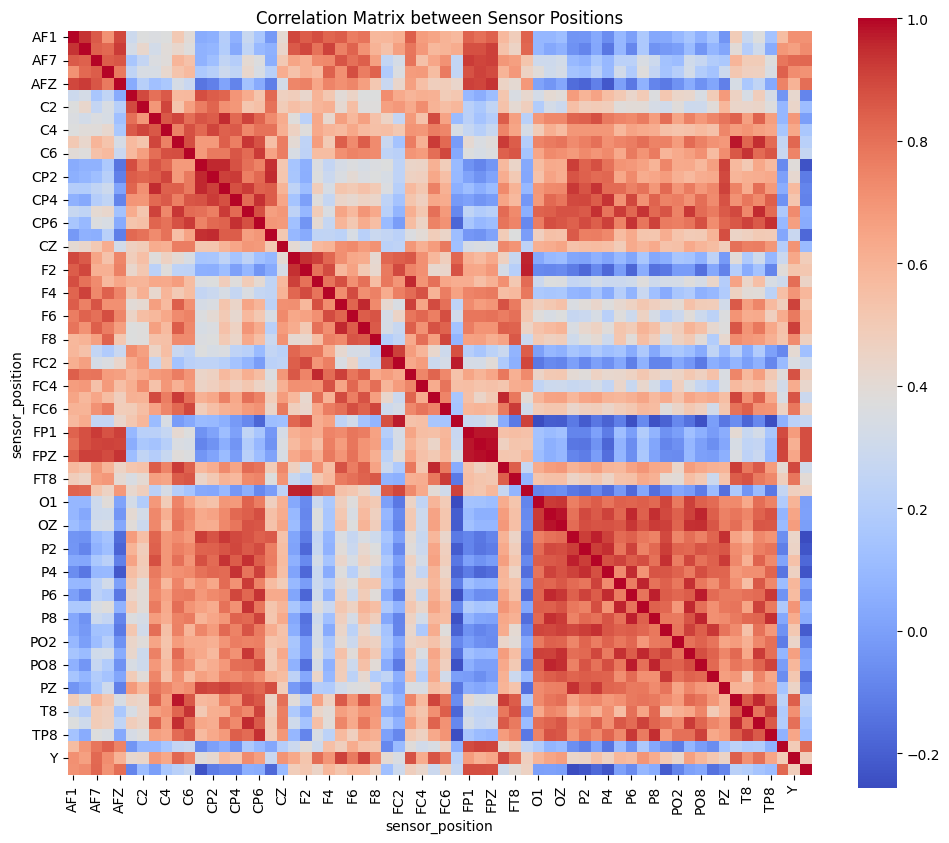

In [25]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title("Correlation Matrix between Sensor Positions")
plt.show()
